**RELEVANT FAQs SOLVED BY TAs**

* In Task 3, by "transformation" of categorical values, do you mean getting dummies for all of them? This does'’ play well for bar charts. ***Good idea.***
 
* Task two asks for a unique index for the final data frame. Is it sufficient to give the data frame a numerical index from 0 - > X? Or should the index be made up of a combination of the different attributes? ***Yes, it has to be a meaningful index.***

* How is the “cabin floor” defined? (see homework 1, task 3.3) If cabin letter indicates the floor, what about the guy in cabin “F E46”? Also the “T” seems like a typo. There were 5 such cases..And what about people who reserved more cabins. **Argue about your decisions; Real world datasets are dirty! (Useful: https://www.encyclopedia-titanica.org/titanic-deckplans)**

# Imports

In [1]:
import math
import pandas as pd
import numpy as np
import glob
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from calendar import monthrange
pd.options.mode.chained_assignment = None

%matplotlib inline

# Table of Contents
 <p><div class="lev1"><a href="#Task-1.-Compiling-Ebola-Data"><span class="toc-item-num">Task 1.&nbsp;&nbsp;</span>Compiling Ebola Data</a></div>
 <div class="lev1"><a href="#Task-2.-RNA-Sequences"><span class="toc-item-num">Task 2.&nbsp;&nbsp;</span>RNA Sequences</a></div>
 <div class="lev1"><a href="#Task-3.-Class-War-in-Titanic"><span class="toc-item-num">Task 3.&nbsp;&nbsp;</span>Class War in Titanic</a></div></p>

In [2]:
DATA_FOLDER = 'Data' # Use the data folder provided in Tutorial 02 - Intro to Pandas.

## Task 1. Compiling Ebola Data

The `DATA_FOLDER/ebola` folder contains summarized reports of Ebola cases from three countries (Guinea, Liberia and Sierra Leone) during the recent outbreak of the disease in West Africa. For each country, there are daily reports that contain various information about the outbreak in several cities in each country.

Use pandas to import these data files into a single `Dataframe`.
Using this `DataFrame`, calculate for *each country*, the *daily average per month* of *new cases* and *deaths*.
Make sure you handle all the different expressions for *new cases* and *deaths* that are used in the reports.

### 1.1 Constants

In [3]:
DEFAULT_NAME_COLUMN_DATE = 'Date'
DEFAULT_NAME_COLUMN_DESCRIPTION = 'Description'
DEFAULT_NAME_COLUMN_TOTAL = 'Totals'
DEFAULT_NAME_COLUMN_COUNTRY = 'Country'

DEFAULT_NAME_ROW_DESCRIPTION_NEW_CASES = 'New cases'
DEFAULT_NAME_ROW_DESCRIPTION_NEW_DEATHS = 'New deaths'

DEFAULT_DATA_FORMAT = '%Y-%m-%d'

The definitions of the basic schema and formats for the given dataset are stored in the following dictionaries

In [4]:
country_keys = ['guinea', 'liberia', 'sl']
paths = {x: DATA_FOLDER + '/ebola/'+ x + '_data' for x in country_keys}
countries = {'guinea': 'Guinea', 'liberia': 'Liberia', 'sl': 'Sierra Leone'}

wanted_columns = {'guinea': ['Date', 'Description', 'Totals'],
                      'liberia': ['Date', 'Variable', 'National'],
                      'sl': ['date', 'variable', 'National']}

date_original_formats = {'guinea': ['%Y-%m-%d', '%y-%m-%d'],
                         'liberia': ['%m/%d/%Y', '%m/%d/%y'],
                         'sl': ['%Y-%m-%d', '%y-%m-%d']}

### 1.2 Auxiliary functions

In [5]:
def sanitize_date(date, original_formats):
    '''
    Transform a date specified in a string with a certain original
    format into a string with the date in the default format.
    '''
    date_rep = None
    try:
        date_rep = datetime.datetime.strptime(date, original_formats[0])
    except ValueError:
        date_rep = datetime.datetime.strptime(date, original_formats[1])
    return date_rep.strftime(DEFAULT_DATA_FORMAT)

In [6]:
def estimate_daily_from_cum(np_list):
    '''
    Given a list of accumulated data, calculate the data for each day.
    It assumes ordered data.
    '''
    last_known_n = -1
    final_list = list()
    for i, elem in np_list.iteritems():
        #elem = float(elem)
        if (math.isnan(elem)):
            final_list.append(0)
        else:
            if (last_known_n == -1):
                final_list.append(0)
            else:
                final_list.append(elem - last_known_n)
            last_known_n = elem
    return np.array(final_list)

### 1.3 Read files

We create a dictionary `dataframe_list` that contains, for each country, the corresponding dataframe.

After reading each data frame we apply the function `sanitize_date` to the `Date` column to make sure that the format used for the date is consistent, and we then sort the rows in each dataframe according to the `Date`.

In [7]:
dataframe_list = {}

for i in country_keys:
    temp_list = []
    all_files = glob.glob(paths[i] + '/*.csv')
    for file in all_files:
        temp_df = pd.read_csv(file)
        temp_list.append(temp_df)
    dataframe_list[i] = pd.concat(temp_list)
    
    # Format dates and order dataframes by date
    dataframe_list[i][wanted_columns[i][0]] = np.array([sanitize_date(x, date_original_formats[i])
                                                        for x in dataframe_list[i][wanted_columns[i][0]]])
    
    dataframe_list[i][wanted_columns[i][0]] = pd.to_datetime(dataframe_list[i][wanted_columns[i][0]])
    dataframe_list[i].sort_values(by=wanted_columns[i][0])

### 1.4 Parsing data for each country

The goal of the parsing processes is to obtain a *standard* datataset for each country. We want to extract the useful data for our task while reorganizing the schema and data format to develop a general coherence.

In particular, we want to obtain the daily number of deaths and new cases registered for each country.

***N.B.*** The resulting dataframes do not have the indexing reformatted. Since those are temporary results that will later be concatenated in a single dataframe, we decided to handle the indexing after this operation.

--

#### 1.4.1 Guinea

In order to parse the Guinea dataset we considered the variables ```New deaths registered``` (or ```New deaths registered today``` when it was used instead of the previous one) and ```Total new cases registered so far```. These variables represent the daily number of deaths and cases respectively.

In [8]:
# Select certain column from the CSV formatted files
parsed_guinea_df = dataframe_list['guinea'][wanted_columns['guinea']]
guinea_wanted_row_list = ['Total new cases registered so far',
                          'New deaths registered',
                          'New deaths registered today']

# Select all the rows that match desired names for 'Description' column
parsed_guinea_df = parsed_guinea_df[parsed_guinea_df['Description'].isin(guinea_wanted_row_list)]

# Rename every row value for 'Description' column 
parsed_guinea_df.loc[parsed_guinea_df['Description'] ==
                     guinea_wanted_row_list[0], 'Description'] = DEFAULT_NAME_ROW_DESCRIPTION_NEW_CASES

parsed_guinea_df.loc[parsed_guinea_df['Description'] ==
                     guinea_wanted_row_list[1], 'Description'] = DEFAULT_NAME_ROW_DESCRIPTION_NEW_DEATHS

parsed_guinea_df.loc[parsed_guinea_df['Description'] ==
                     guinea_wanted_row_list[2], 'Description'] = DEFAULT_NAME_ROW_DESCRIPTION_NEW_DEATHS

# Add 'Country' column to dataframe
parsed_guinea_df[DEFAULT_NAME_COLUMN_COUNTRY] = countries['guinea']

Sample:

In [9]:
parsed_guinea_df.head()

,Date,Description,Totals,Country
3,2014-08-26,New cases,28,Guinea
9,2014-08-26,New deaths,5,Guinea
3,2014-09-23,New cases,29,Guinea
9,2014-09-23,New deaths,3,Guinea
3,2014-09-04,New cases,30,Guinea


#### 1.4.2 Liberia

In order to parse the Liberia dataset we considered the ```Newly reported deaths``` variable, which represents the daily number of deaths. To handle the new cases data we, on the other hand, had to do some manipulations. 

The number of new (daily) cases comes in three different variables (```New Case/s (Suspected)```, ```New Case/s (Probable)``` and ```New Case/s (confirmed)```) that have to be summed up to obtain the total value of new cases.

In [10]:
# Select certain columns from the CSV formatted files
liberia_df = dataframe_list['liberia'][wanted_columns['liberia']]

liberia_wanted_row_list = ['New Case/s (Suspected)',
                   'New Case/s (Probable)',
                   'New case/s (confirmed)',
                   'Newly reported deaths',
                   'Total suspected cases',
                   'Total probable cases',
                   'Total confirmed cases']

However, the data comes with strangely big new cases values for the last days of the report:

In [11]:
liberia_df[(liberia_df['Variable'] == 'New case/s (confirmed)') &
           (liberia_df['Date'].apply(lambda x: x.month) == 12)].sort_values(by=['Date'])

,Date,Variable,National
25,2014-12-01,New case/s (confirmed),1.0
25,2014-12-02,New case/s (confirmed),9.0
25,2014-12-03,New case/s (confirmed),NaN
25,2014-12-04,New case/s (confirmed),2867.0
25,2014-12-05,New case/s (confirmed),2867.0
25,2014-12-06,New case/s (confirmed),2869.0
25,2014-12-07,New case/s (confirmed),2869.0
25,2014-12-08,New case/s (confirmed),2927.0
25,2014-12-09,New case/s (confirmed),2946.0


We concluded that those numbers couldn't be correct. As we found a correlation between those values and the total new cases accumulator for the past days, we assumed the data as been inputted on the wrong part of the table.

The new cases data for the last month of the report were therefore calculated from the daily difference of the cases accumulators, while we took the daily values for the rest of the months.

In [12]:
# Create temporary dataframes for new case entries
# Take accumulated cases for the last month of the report
liberia_df_cum_cases_1 = liberia_df[liberia_df['Variable'].isin(liberia_wanted_row_list[4:7])]
liberia_df_cum_cases_1 = liberia_df_cum_cases_1[liberia_df_cum_cases_1['Date'].map(
    lambda x: x.month == 12 and x.day <= 3)]
liberia_df_cum_cases_1 = liberia_df_cum_cases_1.groupby('Date').sum()

liberia_df_cum_cases_2 = liberia_df[liberia_df['Variable'].isin(liberia_wanted_row_list[0:3])]
liberia_df_cum_cases_2 = liberia_df_cum_cases_2[liberia_df_cum_cases_2['Date'].map(
    lambda x: x.month == 12 and x.day > 3)]
liberia_df_cum_cases_2 = liberia_df_cum_cases_2.groupby('Date').sum()

liberia_df_cum_cases = pd.concat([liberia_df_cum_cases_1, liberia_df_cum_cases_2])
liberia_df_cum_cases['National'] = estimate_daily_from_cum(liberia_df_cum_cases['National'])

# Take daily cases for the other months
liberia_df_new_cases = liberia_df[liberia_df['Variable'].isin(liberia_wanted_row_list[0:3])]
liberia_df_new_cases = liberia_df_new_cases[liberia_df_new_cases['Date'].map(
    lambda x: x.month != 12)]

# Get dataframe with new cases for all months
liberia_df_new_cases = pd.concat([liberia_df_new_cases, liberia_df_cum_cases])

# Sum all of the values for 'Probable', 'Variable' and 'Confirmed' new cases
liberia_df_new_cases = liberia_df_new_cases.groupby('Date').sum()

liberia_df_new_cases['Date'] = liberia_df_new_cases.index
liberia_df_new_cases['Variable'] = DEFAULT_NAME_ROW_DESCRIPTION_NEW_CASES

In [13]:
# Create temporary dataframe for new deaths entries
liberia_df_new_deaths = liberia_df[liberia_df['Variable'] == liberia_wanted_row_list[3]]
liberia_df_new_deaths['Variable'] = DEFAULT_NAME_ROW_DESCRIPTION_NEW_DEATHS

In [14]:
# Create dataframe with new deaths and cases (concatenating the two temporary)
parsed_liberia_df = pd.concat([liberia_df_new_cases, liberia_df_new_deaths])

parsed_liberia_df.rename(columns={'Date': DEFAULT_NAME_COLUMN_DATE,
                                  'Variable': DEFAULT_NAME_COLUMN_DESCRIPTION,
                                  'National': DEFAULT_NAME_COLUMN_TOTAL}, inplace=True)

# Add 'Country' column to dataframe
parsed_liberia_df[DEFAULT_NAME_COLUMN_COUNTRY] = countries['liberia']

Sample:

In [15]:
parsed_liberia_df.head()

,Date,Totals,Description,Country
2014-06-16 00:00:00,2014-06-16,4.0,New cases,Liberia
2014-06-17 00:00:00,2014-06-17,2.0,New cases,Liberia
2014-06-22 00:00:00,2014-06-22,10.0,New cases,Liberia
2014-06-24 00:00:00,2014-06-24,6.0,New cases,Liberia
2014-06-25 00:00:00,2014-06-25,7.0,New cases,Liberia


#### 1.4.3 Sierra Leone

In order to parse the Sierra Leone dataset we followed similar steps as for Liberia. The new cases value has been computed as the sum of the corresponding variables of the table (```new_noncase```, ```new_suspected```, ```new_probable``` and ```new_confirmed```). 

Since the dataset only had total accumulators for the number of deaths, the new death variable was calculated as the difference between days, as previously done with Liberia. The possible missing data for this operation has been handled by setting them to zero, while keeping the the same delta for known points.

In [16]:
# Select certain columns from the CSV formatted files
parsed_sierra_df = dataframe_list['sl'][wanted_columns['sl']]

sierra_wanted_row_list = ['new_noncase', 'new_suspected', 'new_probable', 'new_confirmed',
                   'death_confirmed', 'death_probable', 'death_suspected']

In [17]:
# Create temporary dataframe for new case entries
# (with every row that matches the desired 'variables' column value)
sierra_df_new_cases = parsed_sierra_df[parsed_sierra_df['variable'].isin(
    sierra_wanted_row_list[0:4])]

# Sum all of the values for 'Probable', 'Variable', 'Confirmed' and 'Noncase' new cases
sierra_df_new_cases = sierra_df_new_cases.groupby('date')['National'].apply(
    lambda x: np.array([float(y) for y in x]).sum()).to_frame()

sierra_df_new_cases['date'] = sierra_df_new_cases.index
sierra_df_new_cases['variable'] = DEFAULT_NAME_ROW_DESCRIPTION_NEW_CASES

In [18]:
# Create temporary dataframe for new deaths' accumulator entries
sierra_df_new_deaths_cum = parsed_sierra_df[parsed_sierra_df['variable'].isin(
    sierra_wanted_row_list[4:7])]

# Sum all of the values for 'Probable', 'Suspected' and 'Confirmed' new death accumulators
sierra_df_new_deaths_cum = sierra_df_new_deaths_cum.groupby('date')['National'].apply(
    lambda x: np.array([float(y) for y in x]).sum()).to_frame()

sierra_df_new_deaths_cum['date'] = sierra_df_new_deaths_cum.index
sierra_df_new_deaths_cum['variable'] = 'New deaths accumulator'

# 
sierra_df_new_deaths_cum['National'] = estimate_daily_from_cum(sierra_df_new_deaths_cum['National'])
sierra_df_new_deaths_cum['variable'] = DEFAULT_NAME_ROW_DESCRIPTION_NEW_DEATHS

In [19]:
parsed_sierra_df = pd.concat([sierra_df_new_cases, sierra_df_new_deaths_cum])

parsed_sierra_df.rename(columns={'date': DEFAULT_NAME_COLUMN_DATE,
                                 'variable': DEFAULT_NAME_COLUMN_DESCRIPTION,
                                 'National': DEFAULT_NAME_COLUMN_TOTAL}, inplace=True)

# Add 'Country' column to dataframe
parsed_sierra_df[DEFAULT_NAME_COLUMN_COUNTRY] = countries['sl']

Sample:

In [20]:
parsed_sierra_df.head()

,Totals,Date,Description,Country
date,,,,
2014-08-12,26.0,2014-08-12,New cases,Sierra Leone
2014-08-13,32.0,2014-08-13,New cases,Sierra Leone
2014-08-14,41.0,2014-08-14,New cases,Sierra Leone
2014-08-15,32.0,2014-08-15,New cases,Sierra Leone
2014-08-16,30.0,2014-08-16,New cases,Sierra Leone


### 1.5 Joining the parsed country datatset into a single one

In [21]:
complete_df = pd.concat([parsed_guinea_df, parsed_liberia_df, parsed_sierra_df])
complete_df.reset_index(inplace=True, drop=True)

Samples:

In [22]:
complete_df[42:47]

,Country,Date,Description,Totals
42,Guinea,2014-09-14,New cases,25
43,Guinea,2014-09-14,New deaths,1
44,Liberia,2014-06-16,New cases,4
45,Liberia,2014-06-17,New cases,2
46,Liberia,2014-06-22,New cases,10


Even after handling the NaN troubles during the parsing for some aspects, we still have some to manage

In [23]:
complete_df[complete_df[DEFAULT_NAME_COLUMN_TOTAL].isnull()].head()

,Country,Date,Description,Totals
137,Liberia,2014-12-07,New deaths,NaN
145,Liberia,2014-12-03,New deaths,NaN
155,Liberia,2014-09-20,New deaths,NaN
162,Liberia,2014-12-05,New deaths,NaN
164,Liberia,2014-12-02,New deaths,NaN


As for now, we assume that the missing values equal 0

In [24]:
# Assume NaN values are 0
complete_df = complete_df.fillna(0)

We have seen that the difference in the number of deaths for some rows is negative. It is not a reasonable value and is probably due to an error when keeping track of the accumulated number of deaths, especially during the change of month. We therefore decided to consider 0 instead.

In [25]:
complete_df[complete_df['Totals'].apply(lambda x: int(x)) < 0]

,Country,Date,Description,Totals
387,Sierra Leone,2014-10-01,New deaths,-18


In [26]:
complete_df.loc[complete_df['Totals'].apply(lambda x: int(x)) < 0, 'Totals'] = 0

### 1.6 Calculate for each country, the daily average per month of new cases and deaths

We start grouping by ```Country```, ```Description``` and month, and then calculate the average over the total number of days in the month.

In [27]:
grouped = complete_df.groupby(by=[complete_df.Country, complete_df.Description,
                                  [x.month for x in complete_df.Date]])

In [28]:
calculated_average_df = pd.DataFrame()

for ((country, description, month), values) in grouped:
    days_in_month = monthrange(2014, month)[1]
    entry = {DEFAULT_NAME_COLUMN_COUNTRY: country, 
             'Description': description, 
             'Month': month, 
             'Average': values[DEFAULT_NAME_COLUMN_TOTAL].apply(lambda x: float(x) / days_in_month).sum()}
    calculated_average_df = calculated_average_df.append([entry])

In [29]:
death_average_df = calculated_average_df[calculated_average_df[DEFAULT_NAME_COLUMN_DESCRIPTION] ==
                                         DEFAULT_NAME_ROW_DESCRIPTION_NEW_DEATHS]
cases_average_df = calculated_average_df[calculated_average_df[DEFAULT_NAME_COLUMN_DESCRIPTION] ==
                                         DEFAULT_NAME_ROW_DESCRIPTION_NEW_CASES]

calculated_average_df = pd.merge(death_average_df, cases_average_df, on=[DEFAULT_NAME_COLUMN_COUNTRY, 'Month'])
calculated_average_df.drop([DEFAULT_NAME_COLUMN_DESCRIPTION+'_x',
                            DEFAULT_NAME_COLUMN_DESCRIPTION+'_y'], axis=1, inplace=True)

calculated_average_df = calculated_average_df.rename(columns={'Average_x': 'Death monthly average',
                                                              'Average_y': 'Case monthly average'})

After reordering the columns, the final result is shown in the following table. For each country we calculated the average for the new deaths entries as well as the new cases entries

In [30]:
calculated_average_df = calculated_average_df[['Country', 'Month',
                                               'Death monthly average', 'Case monthly average']]
calculated_average_df

,Country,Month,Death monthly average,Case monthly average
0,Guinea,8,0.548387,4.161290
1,Guinea,9,1.900000,10.466667
2,Guinea,10,0.483871,1.096774
3,Liberia,6,0.466667,1.333333
4,Liberia,7,1.516129,3.032258
5,Liberia,8,6.741935,10.806452
6,Liberia,9,28.833333,51.066667
7,Liberia,10,22.612903,36.741935
8,Liberia,11,6.733333,13.233333
9,Sierra Leone,8,4.258065,22.483871


### 1.7 Plots

We plotted the results for a final visualisation of the obtained data. First by country alone in the following bar charts

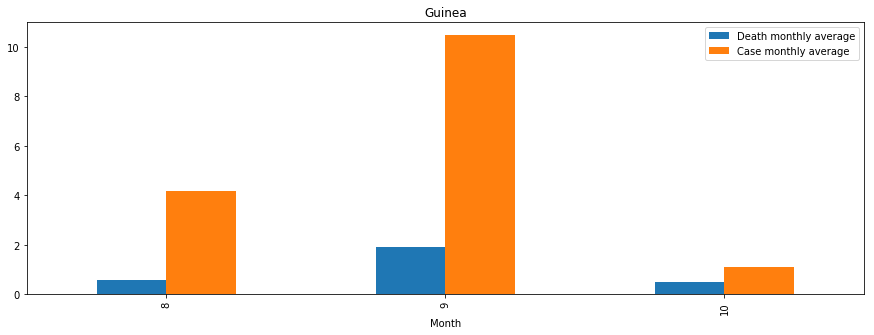

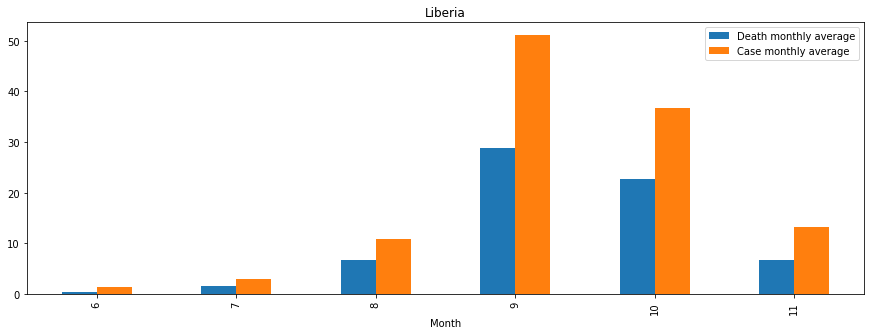

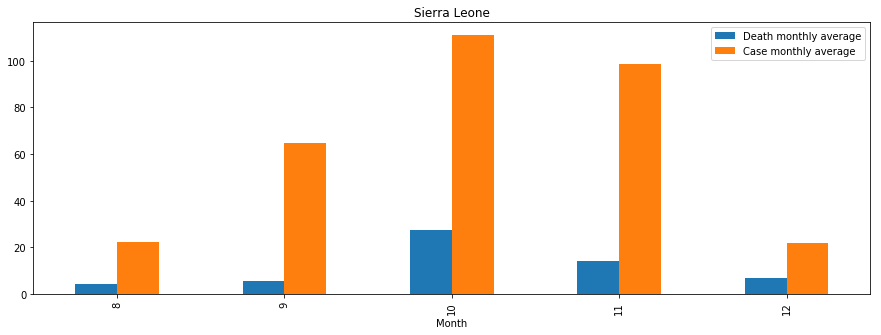

In [31]:
for title, group in calculated_average_df.groupby(DEFAULT_NAME_COLUMN_COUNTRY):
    group.plot(x='Month', title=title, kind="bar", figsize=(15,5))

And lastly as an unique bar chart for all the results in one plot

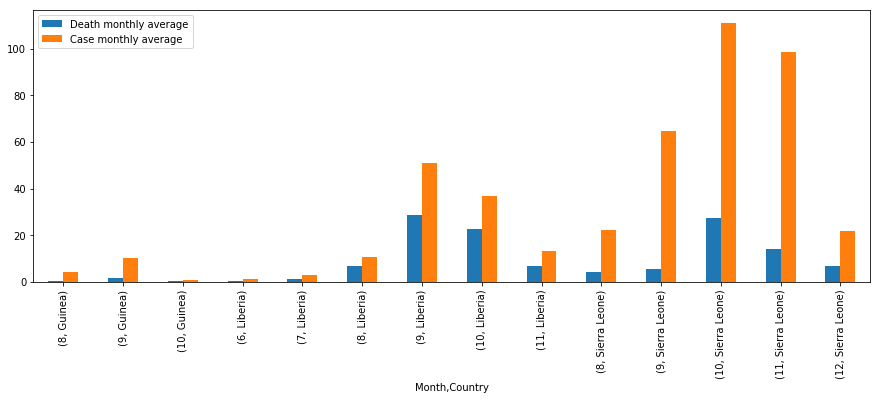

In [32]:
calculated_average_df.plot.bar(x=['Month',DEFAULT_NAME_COLUMN_COUNTRY], figsize=(15,5))

# Task 2. RNA Sequences

In the `DATA_FOLDER/microbiome` subdirectory, there are 9 spreadsheets of microbiome data that was acquired from high-throughput RNA sequencing procedures, along with a 10<sup>th</sup> file that describes the content of each. 

Use pandas to import the first 9 spreadsheets into a single `DataFrame`.
Then, add the metadata information from the 10<sup>th</sup> spreadsheet as columns in the combined `DataFrame`.
Make sure that the final `DataFrame` has a unique index and all the `NaN` values have been replaced by the tag `unknown`.

### 2.1 Read files

We started by importing the nine tables in one single big dataframe

In [33]:
all_files = glob.glob(DATA_FOLDER + '/microbiome' + '/MID*.xls')
raw_df = pd.DataFrame()

for file in all_files:
    file_name = file[file.rfind('/')+1:file.rfind('.')]
    temp_df = pd.read_excel(file, header=None)
    temp_df['BARCODE'] = file_name
    raw_df = raw_df.append(temp_df)

raw_df.head()

,0,1,BARCODE
0,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",2,MID4
1,"Archaea ""Crenarchaeota"" Thermoprotei Sulfoloba...",1,MID4
2,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",1,MID4
3,"Archaea ""Euryarchaeota"" Archaeoglobi Archaeogl...",1,MID4
4,"Archaea ""Euryarchaeota"" Methanopyri Methanopyr...",10,MID4


We the imported the metadata table in another dataframe

In [34]:
metadata_df = pd.read_excel(DATA_FOLDER+'/microbiome'+'/metadata.xls')
metadata_df

,BARCODE,GROUP,SAMPLE
0,MID1,EXTRACTION CONTROL,NaN
1,MID2,NEC 1,tissue
2,MID3,Control 1,tissue
3,MID4,NEC 2,tissue
4,MID5,Control 2,tissue
5,MID6,NEC 1,stool
6,MID7,Control 1,stool
7,MID8,NEC 2,stool
8,MID9,Control 2,stool


### 2.2 Merging the dataframes

The final goal is to obtain a single dataframe for the given data. We will need to obtain a table of the following format:

| Description | Group | Tissue | Stool | Other |
|-------------|-------|--------|-------|-------|
|             |       |        |       |       |
|             |       |        |       |       |
|             |       |        |       |       |


We will fill-in the last three collumns with the sample date we have in the given datatframes. The column will be chosen according to what the metadata provides. The same idea will be followed to fill-in the Group collumn with the correct information

We create three dataframe containing the metadata informations for a single Sample type

In [35]:
stool_metadata_df = metadata_df[metadata_df['SAMPLE'] == 'stool']
tissue_metadata_df = metadata_df[metadata_df['SAMPLE'] == 'tissue']
na_metadata_df = metadata_df[metadata_df['SAMPLE'].isnull()]

Sample:

In [36]:
tissue_metadata_df

,BARCODE,GROUP,SAMPLE
1,MID2,NEC 1,tissue
2,MID3,Control 1,tissue
3,MID4,NEC 2,tissue
4,MID5,Control 2,tissue


We create three dataframes for the different samples according to what we have in the metatada dataframes obtained before

In [37]:
raw_df = pd.merge(raw_df, metadata_df[['BARCODE', 'GROUP']], on=['BARCODE'])
raw_df.rename(columns={0: 'Description', 1: 'Sample'}, inplace=True)

stool_df = raw_df[raw_df['BARCODE'].isin(list(stool_metadata_df['BARCODE']))].drop('BARCODE', axis=1)
stool_df.rename(columns={'Sample': 'Stool'}, inplace=True)
              
tissue_df = raw_df[raw_df['BARCODE'].isin(list(tissue_metadata_df['BARCODE']))].drop('BARCODE', axis=1)
tissue_df.rename(columns={'Sample': 'Tissue'}, inplace=True)
              
na_df = raw_df[raw_df['BARCODE'].isin(list(na_metadata_df['BARCODE']))].drop('BARCODE', axis=1)
na_df.rename(columns={'Sample': 'Other'}, inplace=True)

Sample:

In [38]:
stool_df.head()

,Description,Stool,GROUP
134,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",7,NEC 1
135,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",1,NEC 1
136,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",1,NEC 1
137,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",2,NEC 1
138,"Archaea ""Crenarchaeota"" Thermoprotei Sulfoloba...",5,NEC 1


We merge those three temporary dataframes into a single one

In [39]:
merged_df = pd.merge(stool_df, tissue_df, how='outer', on=['Description', 'GROUP'])
merged_df = pd.merge(merged_df, na_df, how='outer', on=['Description', 'GROUP'])
merged_df.head()

,Description,Stool,GROUP,Tissue,Other
0,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",7.0,NEC 1,23.0,NaN
1,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",1.0,NEC 1,1.0,NaN
2,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",1.0,NEC 1,NaN,NaN
3,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",2.0,NEC 1,2.0,NaN
4,"Archaea ""Crenarchaeota"" Thermoprotei Sulfoloba...",5.0,NEC 1,10.0,NaN


To complete the task, we fill the NaN values of the dataset with the 'unknown' value and we clear the general format of the table

In [40]:
# Fill of the 'unknown' value for NaNs
merged_df.fillna('unknown', inplace=True)

# Final cleaning up of the table schema
merged_df.rename(columns={'GROUP':'Group'}, inplace=True)

merged_df.head()

,Description,Stool,Group,Tissue,Other
0,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",7,NEC 1,23,unknown
1,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",1,NEC 1,1,unknown
2,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",1,NEC 1,unknown,unknown
3,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",2,NEC 1,2,unknown
4,"Archaea ""Crenarchaeota"" Thermoprotei Sulfoloba...",5,NEC 1,10,unknown


In [42]:
## OTHER POSSIBILITY FOR THIS TASK

def return_from_barcode(barcode, dictionary):
    for x in dictionary:
        if barcode in dictionary[x]:
            return x
    return None

parsed_df = raw_df.copy()

groups_dictionary = {}
for group in metadata_df['GROUP'].unique():
    groups_dictionary[group] = metadata_df[metadata_df['GROUP'] == group]['BARCODE'].values

parsed_df['GROUP'] = parsed_df['BARCODE'].map(lambda x: return_from_barcode(x, groups_dictionary))
parsed_df.rename(columns={1: 'VALUE', 0: 'GENUS'}, inplace=True)
parsed_df.reset_index(inplace=True, drop=True)

samples_dictionary = {'Nan': ['MID1']}
for sample in metadata_df['SAMPLE'].unique():
    samples_dictionary[sample] = metadata_df[metadata_df['SAMPLE'] == sample]['BARCODE'].values

parsed_df['SAMPLE'] = parsed_df['BARCODE'].map(lambda x: return_from_barcode(x, samples_dictionary))

parsed_df

,Description,Sample,BARCODE,GROUP,SAMPLE
0,"Archaea ""Crenarchaeota"" Thermoprotei Desulfuro...",2,MID4,NEC 2,tissue
1,"Archaea ""Crenarchaeota"" Thermoprotei Sulfoloba...",1,MID4,NEC 2,tissue
2,"Archaea ""Euryarchaeota"" ""Methanomicrobia"" Meth...",1,MID4,NEC 2,tissue
3,"Archaea ""Euryarchaeota"" Archaeoglobi Archaeogl...",1,MID4,NEC 2,tissue
4,"Archaea ""Euryarchaeota"" Methanopyri Methanopyr...",10,MID4,NEC 2,tissue
5,"Archaea ""Euryarchaeota"" Thermoplasmata Thermop...",1,MID4,NEC 2,tissue
6,"Bacteria ""Actinobacteria"" Actinobacteria Acidi...",1,MID4,NEC 2,tissue
7,"Bacteria ""Actinobacteria"" Actinobacteria Actin...",1,MID4,NEC 2,tissue
8,"Bacteria ""Actinobacteria"" Actinobacteria Actin...",1,MID4,NEC 2,tissue
9,"Bacteria ""Actinobacteria"" Actinobacteria Actin...",1,MID4,NEC 2,tissue


## Task 3. Class War in Titanic

Use pandas to import the data file `Data/titanic.xls`. It contains data on all the passengers that travelled on the Titanic.

In [43]:
from IPython.core.display import HTML
HTML(filename=DATA_FOLDER+'/titanic.html')

Name,Labels,Units,Levels,Storage,NAs
pclass,,,3,integer,0
survived,Survived,,,double,0
name,Name,,,character,0
sex,,,2,integer,0
age,Age,Year,,double,263
sibsp,Number of Siblings/Spouses Aboard,,,double,0
parch,Number of Parents/Children Aboard,,,double,0
ticket,Ticket Number,,,character,0
fare,Passenger Fare,British Pound (\243),,double,1
cabin,,,187,integer,0


For each of the following questions state clearly your assumptions and discuss your findings:
1. Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`. 
2. Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 
3. Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.
4. For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.
5. Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.
6. Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.

In [44]:
titanic_df = pd.read_excel(DATA_FOLDER+'/titanic.xls')
titanic_df

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
5,1,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S,3,NaN,"New York, NY"
6,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1,0,13502,77.9583,D7,S,10,NaN,"Hudson, NY"
7,1,0,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0.0000,A36,S,NaN,NaN,"Belfast, NI"
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2,0,11769,51.4792,C101,S,D,NaN,"Bayside, Queens, NY"
9,1,0,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,PC 17609,49.5042,NaN,C,NaN,22.0,"Montevideo, Uruguay"


In [45]:
metadata_df = pd.read_html(DATA_FOLDER+'/titanic.html', header=0)

# Fills the null values in the first column with the last valid value
metadata_df[1]['Variable'].fillna(method='ffill', inplace=True)

In [46]:
metadata_df[0]

,Name,Labels,Units,Levels,Storage,NAs
0,pclass,NaN,NaN,3.0,integer,0
1,survived,Survived,NaN,NaN,double,0
2,name,Name,NaN,NaN,character,0
3,sex,NaN,NaN,2.0,integer,0
4,age,Age,Year,NaN,double,263
5,sibsp,Number of Siblings/Spouses Aboard,NaN,NaN,double,0
6,parch,Number of Parents/Children Aboard,NaN,NaN,double,0
7,ticket,Ticket Number,NaN,NaN,character,0
8,fare,Passenger Fare,British Pound (\243),NaN,double,1
9,cabin,NaN,NaN,187.0,integer,0


In [47]:
metadata_df[1]

,Variable,Levels
0,pclass,1st
1,pclass,2nd
2,pclass,3rd
3,sex,female
4,sex,male
5,cabin,NaN
6,cabin,A10
7,cabin,A11
8,cabin,A14
9,cabin,A16


### 3.1 Description of attributes
Describe the *type* and the *value range* of each attribute. Indicate and transform the attributes that can be `Categorical`.

In [48]:
for attribute in metadata_df[0]['Name']:
    if titanic_df[attribute].isnull().any():
        print(attribute+' has null values')

age has null values
fare has null values
cabin has null values
embarked has null values
boat has null values
body has null values
home.dest has null values


* pclass: integer; 3 levels: 1, 2 or 3; Can be turned into an integer.
* survived: binary, 0 means that the passenger survived and 1 means that did not survive. Equivalent to a categorical attribute with 2 levels
* name: string
* sex: string; 2 levels: male or female
* age: real number; If it's less than 1 then the passenger was younger than 1 year old. If it's in the form xx.5 then the age is an estimation; (null values possible)
* sibsp: integer
* parch: integer
* ticket: string, but could be reformatted to be an integer
* fare: real number (null values possible)
* cabin: string; 187 levels (null values possible)
* embarked: string; 3 levels: S, C or Q (null values possible)
* boat: string; 28 levels (null values possible)
* body: integer (null values possible)
* home.dest: string (null values possible)

The ones that can be categorical are:

* pclass
* survived
* sex
* cabin
* embarked
* boat

All of them appear in `metadata_df[1]` except `survived`:

In [49]:
value_range_categorical = {'survived': titanic_df['survived'].unique()}
for attribute in metadata_df[1]['Variable'].unique():
    value_range_categorical[attribute] = np.array(metadata_df[1][metadata_df[1]['Variable'] == attribute]['Levels'])

In [50]:
# TRANSFORMATION OPTION 2
# survived is already binary
# We don't transform 'boat' because it won't be used
# We create a variable 'cabin_floor' and then create dummy variables for it

titanic_df_2 = titanic_df.copy()

In [51]:
titanic_df_2['cabin'].fillna(value='', inplace=True)

In [52]:
def find_floor(cabin):
    # Cabin T is in the boat deck
    # We assume cabins in the format F Gxx are in deck F (and therefore in floor 6)
    map_dictionary = {'T': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7}
    if not cabin:
        return None
    else:
        cabin_list = str(cabin).split()
        # Assumes the last cabin listed is the valid one
        # This also makes sure that F Gxx counts as a cabin in deck F (assumption)
        valid_cabin = cabin_list[0]
        return map_dictionary[valid_cabin[0]]

In [53]:
titanic_df_2['cabin_floor'] = titanic_df_2['cabin'].map(lambda x: find_floor(x))

In [54]:
pd.get_dummies(titanic_df_2, columns=['pclass', 'sex', 'embarked','cabin_floor'])

,survived,name,age,sibsp,parch,ticket,fare,cabin,boat,body,...,embarked_Q,embarked_S,cabin_floor_0.0,cabin_floor_1.0,cabin_floor_2.0,cabin_floor_3.0,cabin_floor_4.0,cabin_floor_5.0,cabin_floor_6.0,cabin_floor_7.0
0,1,"Allen, Miss. Elisabeth Walton",29.0000,0,0,24160,211.3375,B5,2,NaN,...,0,1,0,0,1,0,0,0,0,0
1,1,"Allison, Master. Hudson Trevor",0.9167,1,2,113781,151.5500,C22 C26,11,NaN,...,0,1,0,0,0,1,0,0,0,0
2,0,"Allison, Miss. Helen Loraine",2.0000,1,2,113781,151.5500,C22 C26,NaN,NaN,...,0,1,0,0,0,1,0,0,0,0
3,0,"Allison, Mr. Hudson Joshua Creighton",30.0000,1,2,113781,151.5500,C22 C26,NaN,135.0,...,0,1,0,0,0,1,0,0,0,0
4,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",25.0000,1,2,113781,151.5500,C22 C26,NaN,NaN,...,0,1,0,0,0,1,0,0,0,0
5,1,"Anderson, Mr. Harry",48.0000,0,0,19952,26.5500,E12,3,NaN,...,0,1,0,0,0,0,0,1,0,0
6,1,"Andrews, Miss. Kornelia Theodosia",63.0000,1,0,13502,77.9583,D7,10,NaN,...,0,1,0,0,0,0,1,0,0,0
7,0,"Andrews, Mr. Thomas Jr",39.0000,0,0,112050,0.0000,A36,NaN,NaN,...,0,1,0,1,0,0,0,0,0,0
8,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",53.0000,2,0,11769,51.4792,C101,D,NaN,...,0,1,0,0,0,1,0,0,0,0
9,0,"Artagaveytia, Mr. Ramon",71.0000,0,0,PC 17609,49.5042,,NaN,22.0,...,0,0,0,0,0,0,0,0,0,0


### 3.2 Histogram plots
Plot histograms for the *travel class*, *embarkation port*, *sex* and *age* attributes. For the latter one, use *discrete decade intervals*. 

### 3.3 Passengers by cabin floor
Calculate the proportion of passengers by *cabin floor*. Present your results in a *pie chart*.

ax = sns.countplot(x='cabin_floor', data=titanic_df_2)

In [55]:
passengers_per_cabin_floor = {}
for floor in titanic_df_2['cabin_floor'].unique():
    if str(floor) != 'nan':
        passengers_per_cabin_floor[int(floor)] = titanic_df_2[titanic_df_2['cabin_floor'] == floor]['cabin_floor'].count()

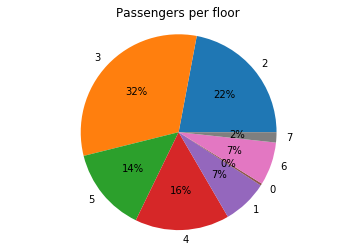

In [56]:
plt.pie(list(passengers_per_cabin_floor.values()), labels=passengers_per_cabin_floor.keys(), autopct='%1.0f%%')
plt.axis('equal')
plt.title('Passengers per floor')
plt.show()

### 3.4 Survivors per class
For each *travel class*, calculate the proportion of the passengers that survived. Present your results in *pie charts*.

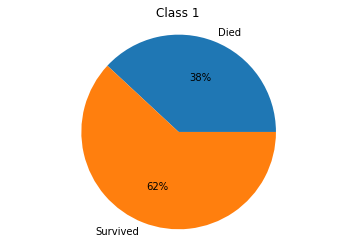

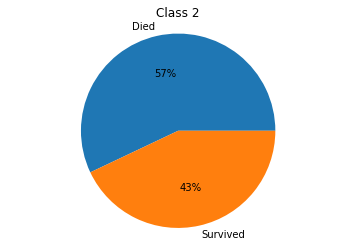

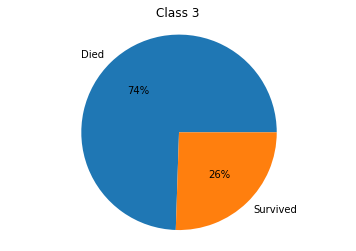

In [57]:
survivors_per_class_df = titanic_df[['pclass', 'survived']].groupby(['pclass', 'survived']).agg(len)

for pclass in range(1,4):
    plt.pie(survivors_per_class_df[pclass], labels=['Died', 'Survived'], autopct='%1.0f%%')
    plt.axis('equal')
    plt.title('Class '+str(pclass))
    plt.show()

### 3.5 Survivors per class and sex
Calculate the proportion of the passengers that survived by *travel class* and *sex*. Present your results in *a single histogram*.

### 3.6 Age categories
Create 2 equally populated *age categories* and calculate survival proportions by *age category*, *travel class* and *sex*. Present your results in a `DataFrame` with unique index.